In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ML Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

# ML Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

### Handling Data ###

In [2]:
# Import expression data
expression = pd.read_csv('data/Gene_expression_log2.csv')
expression.head()

,patient_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,sample_type
0,TCGA-05-4244,0.0,3.460913,3.618474,5.661048,9.731217,0.0,8.435591,1.033652,0.000000,...,9.018679,5.350285,8.197320,9.907260,0.763921,10.088854,11.471137,9.768648,9.170596,1
1,TCGA-05-4249,0.0,3.034867,3.748848,6.515884,9.853335,0.0,7.191819,1.383939,0.000000,...,8.172463,5.980428,8.950002,10.204975,4.411650,9.622978,11.199826,10.153704,9.433116,1
2,TCGA-05-4250,0.0,3.043572,2.811142,5.659257,10.156943,0.0,5.720508,0.000000,0.000000,...,10.033203,5.931168,8.517335,9.722642,4.782796,8.895339,12.408980,10.194166,9.060342,1
3,TCGA-05-4382,0.0,3.624230,3.099968,6.389400,9.658520,0.0,7.913021,0.564232,0.309525,...,9.558593,5.373036,8.441915,9.888267,6.041142,9.828389,12.725185,10.192589,9.376842,1
4,TCGA-05-4384,0.0,2.079088,2.168064,6.200361,9.137001,0.0,8.104766,0.687867,0.000000,...,7.275566,6.340285,9.140127,10.368190,3.160501,9.607079,11.706703,10.763478,9.500392,1


## 3 Year

In [3]:
# Import 1-year exp data
yr_3 = pd.read_csv('data/top_100_DEgenes_3yr.txt', delimiter='\t')
yr_3.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,MAEL|84944,34.385374,3.815821,0.456804,8.353305,6.640000e-17,1.200000e-12
1,WIF1|11197,734.788524,3.071286,0.389516,7.884882,3.150000e-15,2.840000e-11
2,COL4A6|1288,38.422810,-2.225394,0.284721,-7.816044,5.450000e-15,3.280000e-11
3,CIDEC|63924,14.800624,-3.942030,0.510802,-7.717331,1.190000e-14,5.360000e-11
4,NTS|4922,176.357014,-3.859908,0.504927,-7.644489,2.100000e-14,7.570000e-11


In [4]:
# Number of genes in both datasets
len(set(expression.columns).intersection(set(yr_3.gene)))

100

In [5]:
# How many genes are present in the one-year that aren't in the expression data?
# Should be 0
set(yr_3.gene) - set(expression.columns)

set()

In [6]:
common_genes = set(yr_3.gene).intersection(set(expression.columns))
common_genes.add('patient_id')

In [7]:
yr_3_exp = expression[list(common_genes)]

### Label data ###

Which patients have survived?

In [8]:
y = pd.read_csv('data/labels_3yr.csv')
y.head()

,patient_id,Label
0,TCGA-05-4249,1
1,TCGA-05-4389,1
2,TCGA-05-4390,1
3,TCGA-05-4398,1
4,TCGA-05-4415,0


In [9]:
y.Label.value_counts()

1    119
0     90
Name: Label, dtype: int64

In [10]:
patient_id = y['patient_id']
exp_file = y.merge(yr_3_exp, on='patient_id')
exp_file = exp_file.drop(['patient_id'],axis = 1)

In [11]:
exp_file.shape

(209, 101)

### Add metadata

In [12]:
# Add patient_id back
exp_file['patient_id'] = patient_id

# Add metadata to meta_file
metadata_final = pd.read_csv('data/metadata_final_no_os.csv')
meta_file = metadata_final.merge(exp_file, how='right', on='patient_id')

In [13]:
meta_file

,patient_id,age_at_initial_pathologic_diagnosis,gender_FEMALE,gender_MALE,tumor_stage_Early,tumor_stage_Late,tumor_stage_N/A,is_smoker_False,is_smoker_True,Label,...,KCNG1|3755,VTN|7448,MGAT5B|146664,MYO1E|4643,CDH2|1000,SLC6A17|388662,PEBP4|157310,HOXD8|3234,AKAP12|9590,CKMT2|1160
0,TCGA-05-4249,67,0,1,1,0,0,0,1,1,...,1.193961,2.956261,4.724356,9.901724,3.125486,1.551737,6.884989,0.975190,7.650585,2.077106
1,TCGA-05-4389,70,0,1,1,0,0,0,1,1,...,2.510456,3.231018,1.421102,9.401238,3.816313,1.227926,2.510456,4.152062,6.867551,3.124014
2,TCGA-05-4390,58,1,0,1,0,0,0,1,1,...,1.543991,5.069195,1.543991,9.434718,8.660495,3.217650,0.712552,3.403281,9.023034,1.829728
3,TCGA-05-4398,47,1,0,0,1,0,0,1,1,...,2.992678,3.245176,4.548498,11.107276,5.819129,2.780751,4.892784,3.309889,8.132818,3.177439
4,TCGA-05-4415,57,0,1,0,1,0,0,1,0,...,4.481125,11.329482,8.520509,11.990303,3.429991,6.732446,5.174370,10.884087,15.862865,0.917546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,TCGA-MP-A5C7,76,1,0,1,0,0,0,1,1,...,0.500802,1.803186,1.620539,9.215346,1.803186,0.000000,6.560267,3.217169,6.857359,1.803186
205,TCGA-NJ-A4YF,50,1,0,1,0,0,0,1,1,...,2.215741,3.422300,4.728813,10.396498,4.590141,3.501834,4.476621,3.153465,9.820820,8.277218
206,TCGA-NJ-A4YG,65,0,1,1,0,0,0,1,1,...,1.450010,7.832289,3.948059,9.603879,5.542630,2.490288,8.867078,2.631407,7.974856,2.987030
207,TCGA-NJ-A4YQ,69,1,0,1,0,0,0,1,1,...,2.049178,2.590243,4.989121,9.829686,4.005930,2.733289,6.887391,2.431409,7.735915,1.173447


In [14]:
def format_columns(df):
    '''
    Description: This function aims to format all columns in a given dataset.
                 It removes special characters, replaces spaces with _, \
                 and converts to lowercase.
    Parameters: df, the DataFrame to format.
    '''
    import re
    
    df.columns = [re.sub('[^A-Za-z0-9 _]+', '', c).replace(' ', '_').lower() \
                    for c in df.columns]
    return df

In [15]:
# Make all columns lowercase and regex
meta_file = format_columns(meta_file)

### Permutations of Metadata for Feature Selection

In [16]:
meta_file

,patient_id,age_at_initial_pathologic_diagnosis,gender_female,gender_male,tumor_stage_early,tumor_stage_late,tumor_stage_na,is_smoker_false,is_smoker_true,label,...,kcng13755,vtn7448,mgat5b146664,myo1e4643,cdh21000,slc6a17388662,pebp4157310,hoxd83234,akap129590,ckmt21160
0,TCGA-05-4249,67,0,1,1,0,0,0,1,1,...,1.193961,2.956261,4.724356,9.901724,3.125486,1.551737,6.884989,0.975190,7.650585,2.077106
1,TCGA-05-4389,70,0,1,1,0,0,0,1,1,...,2.510456,3.231018,1.421102,9.401238,3.816313,1.227926,2.510456,4.152062,6.867551,3.124014
2,TCGA-05-4390,58,1,0,1,0,0,0,1,1,...,1.543991,5.069195,1.543991,9.434718,8.660495,3.217650,0.712552,3.403281,9.023034,1.829728
3,TCGA-05-4398,47,1,0,0,1,0,0,1,1,...,2.992678,3.245176,4.548498,11.107276,5.819129,2.780751,4.892784,3.309889,8.132818,3.177439
4,TCGA-05-4415,57,0,1,0,1,0,0,1,0,...,4.481125,11.329482,8.520509,11.990303,3.429991,6.732446,5.174370,10.884087,15.862865,0.917546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,TCGA-MP-A5C7,76,1,0,1,0,0,0,1,1,...,0.500802,1.803186,1.620539,9.215346,1.803186,0.000000,6.560267,3.217169,6.857359,1.803186
205,TCGA-NJ-A4YF,50,1,0,1,0,0,0,1,1,...,2.215741,3.422300,4.728813,10.396498,4.590141,3.501834,4.476621,3.153465,9.820820,8.277218
206,TCGA-NJ-A4YG,65,0,1,1,0,0,0,1,1,...,1.450010,7.832289,3.948059,9.603879,5.542630,2.490288,8.867078,2.631407,7.974856,2.987030
207,TCGA-NJ-A4YQ,69,1,0,1,0,0,0,1,1,...,2.049178,2.590243,4.989121,9.829686,4.005930,2.733289,6.887391,2.431409,7.735915,1.173447


In [17]:
# Grab all metadata features 
label_index = meta_file.columns.get_loc('label')
metadata_features = meta_file.iloc[:,1:label_index]

# Identify top 100 expression data
expression_features = meta_file
y_label = expression_features['label']
expression_features = expression_features.drop(['patient_id','label'], axis=1)

In [18]:
expression_features

,age_at_initial_pathologic_diagnosis,gender_female,gender_male,tumor_stage_early,tumor_stage_late,tumor_stage_na,is_smoker_false,is_smoker_true,ect21894,ctcfl140690,...,kcng13755,vtn7448,mgat5b146664,myo1e4643,cdh21000,slc6a17388662,pebp4157310,hoxd83234,akap129590,ckmt21160
0,67,0,1,1,0,0,0,1,9.086128,3.790397,...,1.193961,2.956261,4.724356,9.901724,3.125486,1.551737,6.884989,0.975190,7.650585,2.077106
1,70,0,1,1,0,0,0,1,10.088682,3.985710,...,2.510456,3.231018,1.421102,9.401238,3.816313,1.227926,2.510456,4.152062,6.867551,3.124014
2,58,1,0,1,0,0,0,1,10.236218,3.718822,...,1.543991,5.069195,1.543991,9.434718,8.660495,3.217650,0.712552,3.403281,9.023034,1.829728
3,47,1,0,0,1,0,0,1,9.282104,3.767273,...,2.992678,3.245176,4.548498,11.107276,5.819129,2.780751,4.892784,3.309889,8.132818,3.177439
4,57,0,1,0,1,0,0,1,12.013748,9.250213,...,4.481125,11.329482,8.520509,11.990303,3.429991,6.732446,5.174370,10.884087,15.862865,0.917546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,76,1,0,1,0,0,0,1,9.168253,4.050867,...,0.500802,1.803186,1.620539,9.215346,1.803186,0.000000,6.560267,3.217169,6.857359,1.803186
205,50,1,0,1,0,0,0,1,9.632688,2.954140,...,2.215741,3.422300,4.728813,10.396498,4.590141,3.501834,4.476621,3.153465,9.820820,8.277218
206,65,0,1,1,0,0,0,1,8.967004,3.559614,...,1.450010,7.832289,3.948059,9.603879,5.542630,2.490288,8.867078,2.631407,7.974856,2.987030
207,69,1,0,1,0,0,0,1,9.334711,3.060843,...,2.049178,2.590243,4.989121,9.829686,4.005930,2.733289,6.887391,2.431409,7.735915,1.173447


### Use XGBoost for Feature Selection

[0.02033774 0.         0.         0.0147796  0.071422   0.
 0.         0.         0.         0.01654554 0.00830454 0.01872836
 0.01954582 0.02426739 0.00094286 0.00837736 0.00216278 0.0091318
 0.         0.01250917 0.0077564  0.00088073 0.01566935 0.01071695
 0.00310808 0.01767387 0.00263044 0.00088819 0.00435472 0.00603435
 0.02052084 0.01693253 0.01569492 0.         0.         0.0012082
 0.03260785 0.00748367 0.00535138 0.03560298 0.00477819 0.01635619
 0.00345553 0.01032301 0.01155865 0.00736448 0.         0.00306249
 0.00582027 0.00088648 0.00693274 0.00756072 0.00243077 0.00097149
 0.00712603 0.00902211 0.00831614 0.0056412  0.03018502 0.00428703
 0.         0.00685318 0.02153001 0.01468949 0.00667666 0.01007696
 0.00178038 0.00185627 0.0017379  0.00090458 0.         0.00082796
 0.01990794 0.         0.00335273 0.00752889 0.00236232 0.00292116
 0.00391533 0.         0.01476373 0.         0.05592241 0.01229374
 0.00148622 0.00405054 0.00170879 0.00384598 0.03943815 0.0109598
 0.   

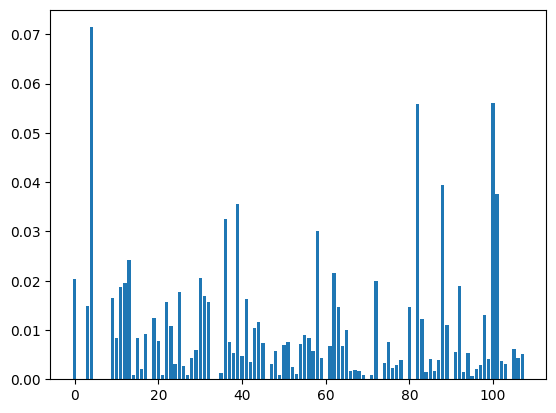

In [19]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

# Define dataset as all features
total_features = expression_features
y_label = np.where(y_label == 0, 1, np.where(y_label == 1, 0, y_label))
X_train, X_test, y_train, y_test = train_test_split(total_features, y_label, test_size=0.2, random_state=42)

# fit model
model = XGBClassifier()
model.fit(X_train, y_train)

# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

#### Using feature importances, perform search over various thresholds with XGBoost

In [20]:
model = XGBClassifier()

# Select features using the threshold
selection = SelectFromModel(model).fit(X_train, y_train)

In [21]:
cols = metadata_final.columns.to_list()
cols.extend(expression_features.columns.to_list())
top_features = [c for b, c, in zip(selection.get_support(), cols) if b]
len(top_features)

33

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.000, n=108, F1 Score: 28.57%
Best Performer: {'eval_metric': <function f1_score at 0x000002C280963430>, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.001, n=91, F1 Score: 35.71%
Best Performer: {'eval_metric': <function f1_score at 0x000002C280963430>, 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 50, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.001, n=83, F1 Score: 28.57%
Best Performer: {'eval_metric': <function f1_score at 0x000002C280963430>, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.002, n=81, F1 Score: 28.57%
Best Performer: {'eval_metric': <function f1_score at 0x000002C280963430>, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10, 'random_

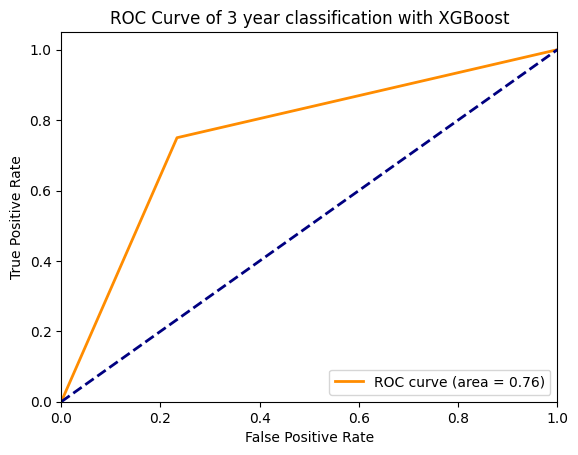

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc

# Define the list of thresholds
threshold = np.arange(0, 0.035, 0.0005)

n = []
best_threshold = []
test_acc = []
grid_search_result = []

classification_reports = []
fpr_global = []
tpr_global = []
thresholds_global = []
confusion_matrices = []

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10],
    'learning_rate': [1e-2, 1e-1, 1, 1e2, 1e3],
    'random_state': [42],
    'eval_metric' : [f1_score]
}
for thresh in threshold:
    
    # Select features using the threshold
    selection = SelectFromModel(XGBClassifier(), threshold=thresh).fit(X_train, y_train)
    select_X_train = selection.transform(X_train)
    
    # Train the model
    selection_model = XGBClassifier()
    grid_search = GridSearchCV(selection_model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)
    
    # Evaluate the model
    select_X_test = selection.transform(X_test)

    y_pred = grid_search.predict(select_X_test)
    predictions = [round(value, 3) for value in y_pred]
    accuracy = f1_score(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Best Performer:", grid_search.best_params_)
    best_threshold.append(thresh)
    n.append(select_X_train.shape[1])
    test_acc.append(accuracy)

    # Calculate and store the classification report
    report = classification_report(y_test, y_pred, digits=4)
    classification_reports.append(report)

    # Save ROC params
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    fpr_global.append(fpr)
    tpr_global.append(tpr)
    thresholds_global.append(thresholds)

    # Save confusion matrix
    cm = confusion_matrix(y_test, predictions)
    confusion_matrices.append(cm)

print("------------------------------------------")
print('RESULTS:')
best_acc_ind = np.argmax(test_acc)
best_acc = np.max(test_acc)
best_threshold = best_threshold[best_acc_ind]
best_n = n[best_acc_ind]
print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (best_threshold,best_n, best_acc*100.0))

best_classification_report = classification_reports[best_acc_ind]
print(best_classification_report)
best_confusion_matrix = confusion_matrices[best_acc_ind]
print(best_confusion_matrix)

best_fpr = fpr_global[best_acc_ind]
best_tpr = tpr_global[best_acc_ind]
best_thresholds = thresholds_global[best_acc_ind]

# Calculate the AUC
roc_auc = auc(best_fpr, best_tpr)

plt.figure()
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of 3 year classification with XGBoost')
plt.legend(loc="lower right")
plt.show()

In [23]:
# for i in range(len(y_pred)):
cm = confusion_matrix(y_test, y_pred)
confusion_table = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))

In [24]:
print(confusion_table)

Predicted   0   1
Actual           
0          18  12
1           4   8


In [25]:
confusion_matrix(y_test, predictions)

array([[18, 12],
       [ 4,  8]], dtype=int64)

In [26]:
print("Best Performer:", grid_search.best_params_)

Best Performer: {'eval_metric': <function f1_score at 0x000002C280963430>, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'random_state': 42}


In [27]:
grid_search.best_params_

{'eval_metric': <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 50,
 'random_state': 42}

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69        30
           1       0.40      0.67      0.50        12

    accuracy                           0.62        42
   macro avg       0.61      0.63      0.60        42
weighted avg       0.70      0.62      0.64        42



#### Do it with SVM

Fitting 5 folds for each of 30 candidates, totalling 150 fits
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  1
Best Score: 0.6256067588325653
Thresh=0.000, n=108, F1 Score: 50.00%
Best Performer: {'C': 0.1, 'kernel': 'linear', 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  2
Best Score: 0.6268826935240597
Thresh=0.001, n=83, F1 Score: 37.04%
Best Performer: {'C': 0.1, 'kernel': 'linear', 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  3
Best Score: 0.6289306477751154
Thresh=0.002, n=76, F1 Score: 42.86%
Best Performer: {'C': 0.1, 'kernel': 'linear', 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 

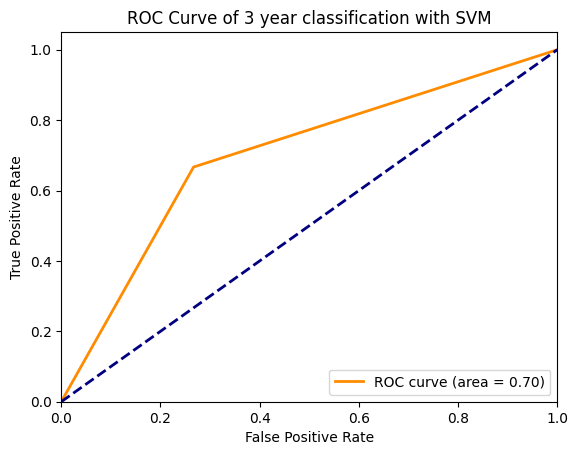

In [30]:
# Define the list of thresholds
threshold = np.arange(0, 0.05, 0.001)
ind = 1
n = []
best_threshold = []
test_acc = []
grid_search_results = []

classification_reports = []
fpr_global = []
tpr_global = []
thresholds_global = []
confusion_matrices = []

param_grid_XGBoost = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10],
    'learning_rate': [1e-2, 1e-1, 1, 1e2, 1e3],
    'random_state': [42],
    'eval_metric' : [f1_score]
}

# SVM Classifier
model = svm.SVC()
param_grid = {'C': [0.1,0.5,1,2,5,10],
            'kernel': ['linear','rbf',],
            'random_state': [42]}

for thresh in threshold:
    
    # Select features using the threshold
    selection = SelectFromModel(XGBClassifier(), threshold=thresh).fit(X_train, y_train)
    select_X_train = selection.transform(X_train)
    
    # Train the model
    selection_model = XGBClassifier()
    grid_search = GridSearchCV(selection_model, param_grid_XGBoost, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)
    
    # Evaluate the model
    model = svm.SVC()
    print("------------------------------------------")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)
    print("Iteration ", ind)
    best_score = grid_search.best_score_
    print("Best Score:", best_score)
    grid_search_results.append(grid_search)
    ind += 1

    # Evaluate the model
    select_X_test = selection.transform(X_test)
    # Perform prediction using the best parameters
    y_pred = grid_search.predict(select_X_test) 
    # Calculate the accuracy of the model
    accuracy = f1_score(y_test, y_pred)
    predictions = [round(value, 3) for value in y_pred]

    print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Best Performer:", grid_search.best_params_)
    best_threshold.append(thresh)
    n.append(select_X_train.shape[1])
    test_acc.append(accuracy)

    # Calculate and store the classification report
    report = classification_report(y_test, y_pred, digits=4)
    classification_reports.append(report)

    # Save ROC params
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    fpr_global.append(fpr)
    tpr_global.append(tpr)
    thresholds_global.append(thresholds)

    # Save confusion matrix
    cm = confusion_matrix(y_test, predictions)
    confusion_matrices.append(cm)

print("------------------------------------------")
print('RESULTS:')
print("Iteration ", ind)
best_acc_ind = np.argmax(test_acc)
best_acc = np.max(test_acc)
best_threshold = best_threshold[best_acc_ind]
best_n = n[best_acc_ind]
print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (best_threshold,best_n, best_acc*100.0))

best_classification_report = classification_reports[best_acc_ind]
print(best_classification_report)
best_confusion_matrix = confusion_matrices[best_acc_ind]
print(best_confusion_matrix)

best_fpr = fpr_global[best_acc_ind]
best_tpr = tpr_global[best_acc_ind]
best_thresholds = thresholds_global[best_acc_ind]

# Calculate the AUC
roc_auc = auc(best_fpr, best_tpr)

plt.figure()
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of 3 year classification with SVM')
plt.legend(loc="lower right")
plt.show()